This dataset contains of features that are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image.
The target is to classify tumor as 'malignant' or 'benign'.

Attribute Information:

1) ID number
2) Diagnosis (M = malignant, B = benign)

3-32)

Ten real-valued features are computed for each cell nucleus:

a) radius (mean of distances from center to points on the perimeter)

b) texture (standard deviation of gray-scale values)

c) perimeter

d) area

e) smoothness (local variation in radius lengths)

f) compactness (perimeter^2 / area - 1.0)

g) concavity (severity of concave portions of the contour)

h) concave points (number of concave portions of the contour)

i) symmetry

j) fractal dimension ("coastline approximation" - 1)




In [1]:
#importing all the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from  sklearn.svm import SVC
import scikitplot
from matplotlib.colors import ListedColormap
from sklearn.metrics import f1_score, accuracy_score, recall_score, classification_report,precision_score,confusion_matrix,roc_curve,auc
from scipy import interp
import warnings
warnings.filterwarnings('ignore')

The problem requires us to classify the tumor as malignant or benign. The data set contains ten real_valued features obtained from images of tumor mass. 

In [2]:
#Importing the data
data = pd.read_csv(r"C:\Users\deadeth0\Documents\Predictive HW\wdbc.data", header = None)

In [3]:
#Adding column names.

col_names = ['id', 'target', 'mean radius', 'mean texture', 'mean perimeter',
       'mean area', 'mean smoothness', 'mean compactness',
       'mean concavity', 'mean concave points', 'mean symmetry',
       'mean fractal dimension', 'radius error', 'texture error',
       'perimeter error', 'area error', 'smoothness error',
       'compactness error', 'concavity error', 'concave points error',
       'symmetry error', 'fractal dimension error', 'worst radius',
       'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry',
       'worst fractal dimension']
data.columns = col_names

In [4]:
#Viewing the loaded data
#Summarising the data for the two different target variables
data.head()
data.groupby('target').mean()

,id,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
target,,,,,,,,,,,,,,,,,,,,,
B,2.654382e+07,12.146524,17.914762,78.075406,462.790196,0.092478,0.080085,0.046058,0.025717,0.174186,...,13.379801,23.515070,87.005938,558.899440,0.124959,0.182673,0.166238,0.074444,0.270246,0.079442
M,3.681805e+07,17.462830,21.604906,115.365377,978.376415,0.102898,0.145188,0.160775,0.087990,0.192909,...,21.134811,29.318208,141.370330,1422.286321,0.144845,0.374824,0.450606,0.182237,0.323468,0.091530


As we can see from the above result, there is a lot of difference between the values of variables (in the order of 10^2). So we will be scaling the data. To do this we use StandardScaler function in scikitlearn. It performs standardisation on data. Before doing this we need to pre-process the data. We do it in the following step.

In [5]:
#Data pre processing 
#Step 1. Changing the target variable to numeric values 0 and 1. Malignant = 0 and Beningn = 1
data['target']= pd.Series(np.where(np.array(data['target'])=='M',1,0))
data.groupby('target').count().iloc[:,1]

target
0    357
1    212
Name: mean radius, dtype: int64

In [6]:
print("Here the base rate for positive cancer predictions is ",100*212/(357+212),". There is skew present in the data. If we simply predict row as belonging to the majority class we will have an accuracy of ~63.75%. So our model should have a accuracy greater than this value. Also, in this problem recall and precision, inplace of accuracy should be used to evaluate the performance of model. Recall tells us out of all the positive cases predicted,how many are actually positive and precision tells us out of all actual positive cases how many did our model predict correctly. F1 score, which is the harmonic mean of precision and recall can also be used.")

Here the base rate for positive cancer predictions is  37.25834797891037 . There is skew present in the data. If we simply predict row as belonging to the majority class we will have an accuracy of ~63.75%. So our model should have a accuracy greater than this value. Also, in this problem recall and precision, inplace of accuracy should be used to evaluate the performance of model. Recall tells us out of all the positive cases predicted,how many are actually positive and precision tells us out of all actual positive cases how many did our model predict correctly. F1 score, which is the harmonic mean of precision and recall can also be used.


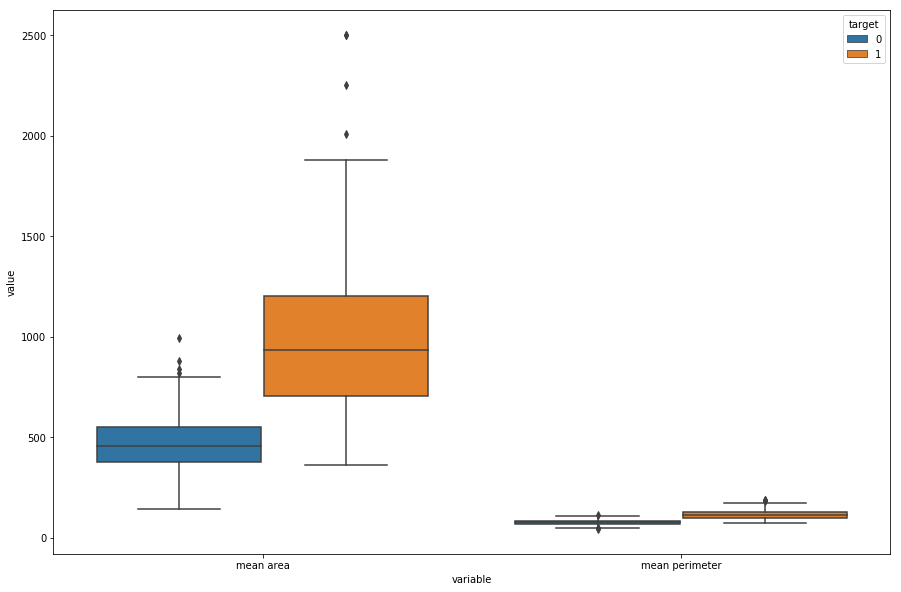

In [7]:
#We can plot some box plots to visualize the variables
#Step 2: Understanding the data and different variables present 
melted_data = pd.melt(data,id_vars = "target",value_vars = [ 'mean area', 'mean perimeter'])
plt.figure(figsize = (15,10))
sns.boxplot(x = "variable", y = "value", hue="target",data= melted_data)
plt.show()

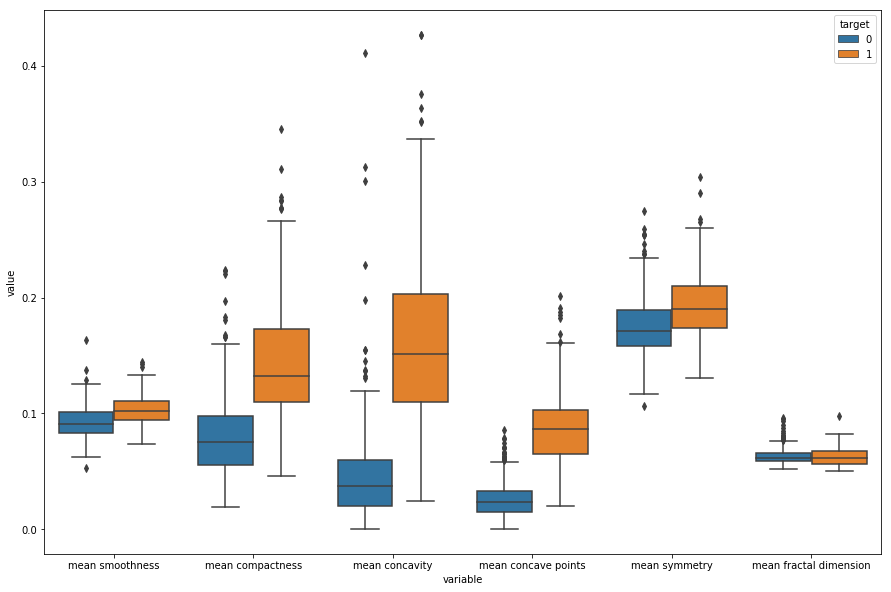

In [8]:
melted_data = pd.melt(data,id_vars = "target",value_vars = [ 
        'mean smoothness', 'mean compactness',
       'mean concavity', 'mean concave points', 'mean symmetry',
       'mean fractal dimension'])
plt.figure(figsize = (15,10))
sns.boxplot(x = "variable", y = "value", hue="target",data= melted_data)
plt.show()

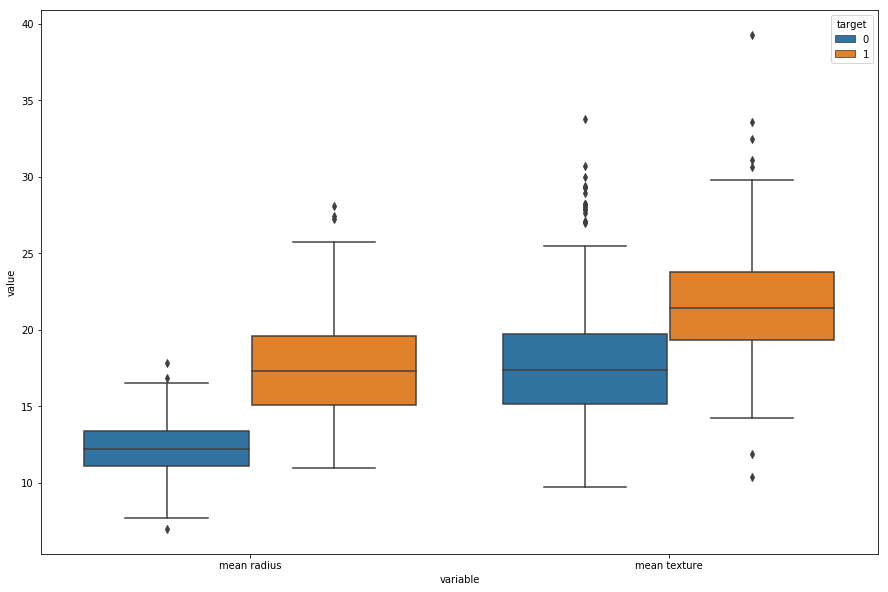

In [9]:
melted_data = pd.melt(data,id_vars = "target",value_vars = [ 'mean radius', 'mean texture'])
plt.figure(figsize = (15,10))
sns.boxplot(x = "variable", y = "value", hue="target",data= melted_data)
plt.show()

In [10]:
#From the above box plots we see that there is difference between the values for malignant and beningn tumors.
#To establish statisticcal significance between the two groups t-test can be further performed. 

In [11]:
#Splitting the data and scaling the data. I came up with test size = 0.33 after experimenting with different values
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,2:],data.iloc[:,1], test_size = 0.33, random_state = 122)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled =  scaler.transform(X_test)

For each algorithm, first we will build a model using random values for hyperparameters. Then, we will compare the accuracy of the model for testing and training data. If the accuracy for testing data is significantly less than that for training data it signals overfitting. In case of overfitting the model memorizes the idisyncracies of training data and fails to learn the general pattern of the data, this results in a high accuracy for training data but a low accuracy for testing data. To overcome this issue we need to tune hyperparametes. In the exercise first I will plot the accuracy values by looping through different values of hyperparameter and then I will use GridSearchCV to find the best parameters of the model.

Now we will start building models. First one we will try is Decision tree.

# #Decision Tree


In [12]:
# First I built a simple decision tree classifier with specifying random hyperparameters:
#Decision Tree Model 1
dtc = DecisionTreeClassifier(max_depth = 2, random_state=10)
dtc.fit(X_train_scaled,y_train).score(X_test_scaled,y_test)

scores = cross_val_score(dtc, X_train_scaled, y_train, cv=4)
scores.mean()

print("Prediction Accuracy: ",accuracy_score(y_test, dtc.predict(X_test_scaled)))
print("Average Accuracy by cross validation: ",scores.mean())
print("Recall: ",recall_score(y_test, dtc.predict(X_test_scaled)))
print("F-score: ",f1_score(y_test, dtc.predict(X_test_scaled)))
print("Precision score: ",precision_score(y_test, dtc.predict(X_test_scaled)))
print("Confusion Matrix: \n",confusion_matrix(y_test, dtc.predict(X_test_scaled)))


Prediction Accuracy:  0.9468085106382979
Average Accuracy by cross validation:  0.9002467105263159
Recall:  0.9104477611940298
F-score:  0.9242424242424243
Precision score:  0.9384615384615385
Confusion Matrix: 
 [[117   4]
 [  6  61]]


Recall and precision values are 91 and 93.8, respectively. Out of 67 actual positive cases in our test data, our model could only predict 61 as being positive (actual cancer) and predicted remaining 6 to be negative(false negative). 

AUC value : 0.964228444554089


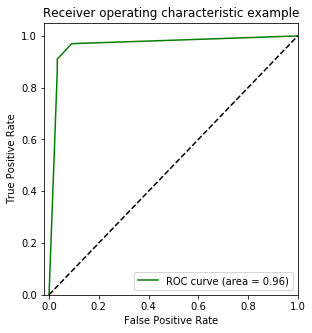

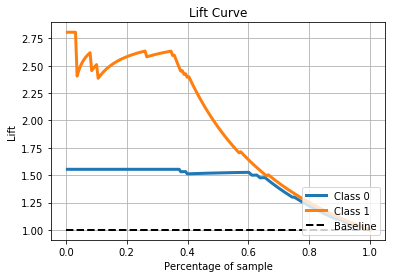

In [13]:
a = dtc.predict_proba(X_test_scaled)
fpr, tpr, thresholds = roc_curve(y_test, a[:, 1])
roc_auc = auc(fpr, tpr)

print("AUC value :", roc_auc)
fig = plt.figure(num=None, figsize=(10, 5))

ax1 = plt.subplot("121")
ax1 = plt.plot(fpr, tpr, color='green',
          label='ROC curve (area = %0.2f)' % roc_auc)
ax1 = plt.plot([0, 1], [0, 1], color='black',  linestyle='--')
ax1 = plt.xlim([-0.02, 1.0])
ax1 = plt.ylim([0.0, 1.05])
ax1 = plt.xlabel('False Positive Rate')
ax1 = plt.ylabel('True Positive Rate')
ax1 = plt.title('Receiver operating characteristic example')
ax1 = plt.legend(loc="lower right")
ax2 = plt.subplot("121")
ax2 = scikitplot.metrics.plot_lift_curve(y_test, a[:], title='Lift Curve')
plt.show()

The predictive accuracy obtained is 94%. This model may be overfit. We try to improve the model further next. The AUC score is 0.96.

In [14]:
# Next I built a another decision tree classifier with random hyperparameters:
#Decision Tree Model 2
dtc = DecisionTreeClassifier(max_depth=20, min_samples_leaf = 12,random_state=10)
dtc.fit(X_train_scaled,y_train).score(X_test_scaled,y_test)

scores = cross_val_score(dtc, X_train_scaled, y_train, cv=4)
scores.mean()

print("Prediction Accuracy: ",accuracy_score(y_test, dtc.predict(X_test_scaled)))
print("Average Accuracy by cross validation: ",scores.mean())
print("Recall: ",recall_score(y_test, dtc.predict(X_test_scaled)))
print("F-score: ",f1_score(y_test, dtc.predict(X_test_scaled)))
print("Precision score: ",precision_score(y_test, dtc.predict(X_test_scaled)))
print("Confusion Matrix: \n",confusion_matrix(y_test, dtc.predict(X_test_scaled)))
## We see that the accuracy decreases. This may be due to underfitting of model.

Prediction Accuracy:  0.9308510638297872
Average Accuracy by cross validation:  0.9212719298245615
Recall:  0.8656716417910447
F-score:  0.8992248062015503
Precision score:  0.9354838709677419
Confusion Matrix: 
 [[117   4]
 [  9  58]]


AUC value : 0.9861847785864069


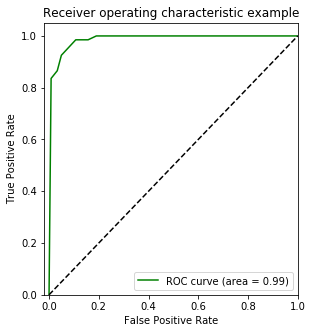

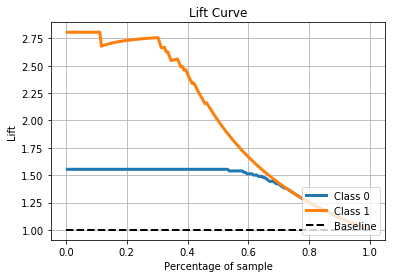

In [15]:
a = dtc.predict_proba(X_test_scaled)
fpr, tpr, thresholds = roc_curve(y_test, a[:, 1])
roc_auc = auc(fpr, tpr)
roc_auc
print("AUC value :", roc_auc)
fig = plt.figure(num=None, figsize=(10, 5))

ax1 = plt.subplot("121")
ax1 = plt.plot(fpr, tpr, color='green',
          label='ROC curve (area = %0.2f)' % roc_auc)
ax1 = plt.plot([0, 1], [0, 1], color='black',  linestyle='--')
ax1 = plt.xlim([-0.02, 1.0])
ax1 = plt.ylim([0.0, 1.05])
ax1 = plt.xlabel('False Positive Rate')
ax1 = plt.ylabel('True Positive Rate')
ax1 = plt.title('Receiver operating characteristic example')
ax1 = plt.legend(loc="lower right")
ax2 = plt.subplot("121")
ax2 = scikitplot.metrics.plot_lift_curve(y_test, a[:], title='Lift Curve')
plt.show()

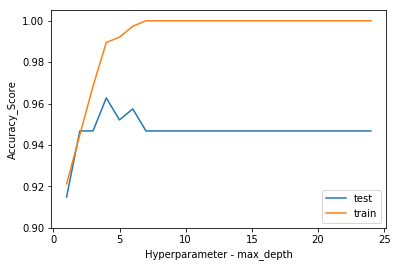

In [16]:
# Next, I ran a loop to find the best hyper-parameter
parameter_range = range(1,25)
train_accuracy_score =[]
test_accuracy_score = []
for i in parameter_range:
    dct1 = DecisionTreeClassifier(max_depth =i,random_state=22)
    dct1 = dct1.fit(X_train_scaled, y_train)
    train_prediction=dct1.predict(X_train_scaled)
    train_accuracy_score.append(accuracy_score(y_train, train_prediction))
    test_prediction=dct1.predict(X_test_scaled)
    test_accuracy_score.append(accuracy_score(y_test, test_prediction))
line1, =plt.plot(parameter_range, test_accuracy_score,label='test_accuracy_score')
line2, =plt.plot(parameter_range, train_accuracy_score,label='train_accuracy_score')
plt.xlabel("Hyperparameter - max_depth")
plt.ylabel("Accuracy_Score")
plt.ylim(0.9,1.005)
plt.legend((line1, line2), ('test', 'train'))
plt.show()

##The graph shows accuracies of test and train data for different values of max_depth. In the above graph beyond max_dept = 3 we see the effect of overfitting.  The accuracy of test and train data diverge.
##Now for this max_depth value we will try to find value for min_samples_leaf in the following code.

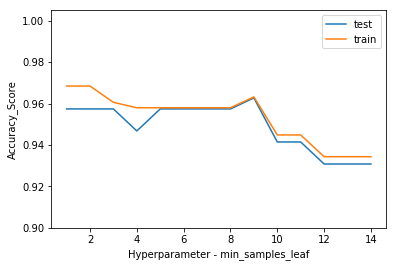

In [17]:
parameter_range = range(1,15)
train_accuracy_score =[]
test_accuracy_score = []
for i in parameter_range:
    dct1 = DecisionTreeClassifier(min_samples_leaf =i, max_depth = 3,random_state=10)
    dct1 = dct1.fit(X_train_scaled, y_train)
    train_prediction=dct1.predict(X_train_scaled)
    train_accuracy_score.append(accuracy_score(y_train, train_prediction))
    test_prediction=dct1.predict(X_test_scaled)
    test_accuracy_score.append(accuracy_score(y_test, test_prediction))
line1, =plt.plot(parameter_range, test_accuracy_score,label='test_accuracy_score')
line2, =plt.plot(parameter_range, train_accuracy_score,label='train_accuracy_score')
plt.xlabel("Hyperparameter - min_samples_leaf")
plt.ylabel("Accuracy_Score")
plt.ylim(0.9,1.005)
plt.legend((line1, line2), ('test', 'train'))
plt.show()

From the above graph we observe that at min_samples_leaf 4 to 8 the accuracy for test and train data is same. After this value the accuracy for test data decreases. This is due to overfitting.

###Best Decision Tree Model

In [18]:
#In model 3, I tried fitting the model with the above parameters.
best_decision_tree = DecisionTreeClassifier(max_depth=3,min_samples_leaf=8,random_state=12)
best_decision_tree.fit(X_train_scaled, y_train).score(X_test_scaled, y_test)
#scores = cross_val_score(best_decision_tree, X_train_scaled, y_train, cv=4)##Not used

print("Prediction Accuracy: ",accuracy_score(y_test, best_decision_tree.predict(X_test_scaled)))
print("Recall: ",recall_score(y_test, best_decision_tree.predict(X_test_scaled)))
print("F-score: ",f1_score(y_test, best_decision_tree.predict(X_test_scaled)))
print("Precision score: ",precision_score(y_test, best_decision_tree.predict(X_test_scaled)))
print("Confusion Matrix: \n",confusion_matrix(y_test, best_decision_tree.predict(X_test_scaled)))

Prediction Accuracy:  0.9574468085106383
Recall:  0.9552238805970149
F-score:  0.9411764705882353
Precision score:  0.927536231884058
Confusion Matrix: 
 [[116   5]
 [  3  64]]


AUC value : 0.9861847785864069


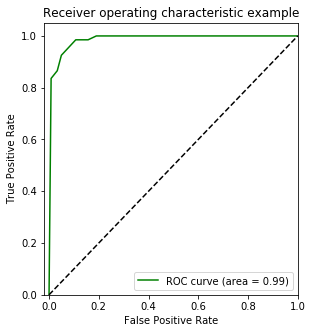

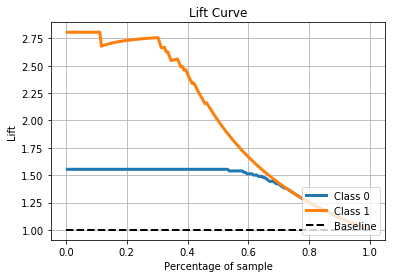

In [19]:
a = dtc.predict_proba(X_test_scaled)
fpr, tpr, thresholds = roc_curve(y_test, a[:, 1])
roc_auc = auc(fpr, tpr)
roc_auc
print("AUC value :", roc_auc)
fig = plt.figure(num=None, figsize=(10, 5))

ax1 = plt.subplot("121")
ax1 = plt.plot(fpr, tpr, color='green',
          label='ROC curve (area = %0.2f)' % roc_auc)
ax1 = plt.plot([0, 1], [0, 1], color='black',  linestyle='--')
ax1 = plt.xlim([-0.02, 1.0])
ax1 = plt.ylim([0.0, 1.05])
ax1 = plt.xlabel('False Positive Rate')
ax1 = plt.ylabel('True Positive Rate')
ax1 = plt.title('Receiver operating characteristic example')
ax1 = plt.legend(loc="lower right")
ax2 = plt.subplot("121")
ax2 = scikitplot.metrics.plot_lift_curve(y_test, a[:], title='Lift Curve')
plt.show()

The above model gives the highest prediciton accuracy. We see that the accuracy and recall increases from the above two models. In cancer prediction recall can also be used to test model accuracy because it is very dangerous to predict a false negative or false positive.

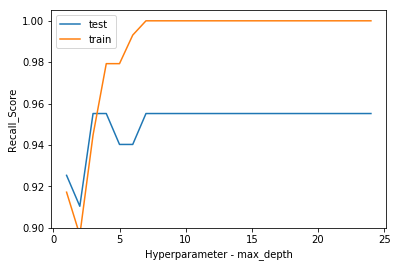

In [20]:
# Next, I ran a loop to find the best hyper-parameter
parameter_range = range(1,25)
train_accuracy_score =[]
test_accuracy_score = []
for i in parameter_range:
    dct1 = DecisionTreeClassifier(max_depth =i, random_state=30)
    dct1 = dct1.fit(X_train_scaled, y_train)
    train_prediction=dct1.predict(X_train_scaled)
    train_accuracy_score.append(recall_score(y_train, train_prediction))
    test_prediction=dct1.predict(X_test_scaled)
    test_accuracy_score.append(recall_score(y_test, test_prediction))
line1, =plt.plot(parameter_range, test_accuracy_score,label='test_accuracy_score')
line2, =plt.plot(parameter_range, train_accuracy_score,label='train_accuracy_score')
plt.xlabel("Hyperparameter - max_depth")
plt.ylabel("Recall_Score")
plt.ylim(0.9,1.005)

plt.legend((line1, line2), ('test', 'train'))
plt.show()

Above graph shows the recall score for different values of max_depth. We clearly see the underfit and overfit regions.
GridSearchCV can also be used to determine the best model.

In [21]:
#hyper-parameter tuning using grid search
l =[i for i in range(1,30)]
k = [i for i in range(1,11)]
parameters = {'max_depth':l, 'min_samples_leaf':k}
dt = DecisionTreeClassifier()
clf = GridSearchCV(dt, parameters,scoring='accuracy' , cv=5)
clf.fit(X_train_scaled, y_train)
clf.best_score_
print("Parameters of best estimator:",clf.best_params_)
#selecting the best estimator
clf.best_estimator_.fit(X_train_scaled,y_train).score(X_test_scaled,y_test)
print("Prediction Accuracy: ",accuracy_score(y_test, clf.predict(X_test_scaled)))
print("Recall: ",recall_score(y_test, clf.predict(X_test_scaled)))
print("F-score: ",f1_score(y_test, clf.predict(X_test_scaled)))
print("Precision score: ",precision_score(y_test, clf.predict(X_test_scaled)))
print("Confusion Matrix: \n",confusion_matrix(y_test, clf.predict(X_test_scaled)))
# We see that the prediction accuracy and recall for this model is a bit less than the above model

Parameters of best estimator: {'max_depth': 4, 'min_samples_leaf': 7}
Prediction Accuracy:  0.9574468085106383
Recall:  0.9552238805970149
F-score:  0.9411764705882353
Precision score:  0.927536231884058
Confusion Matrix: 
 [[116   5]
 [  3  64]]


AUC value : 0.9913038115209079


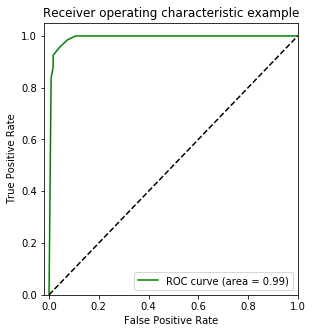

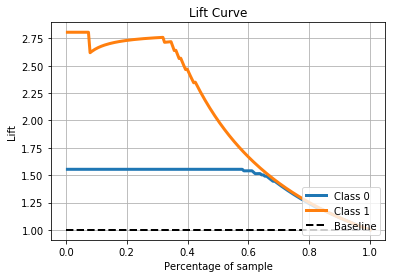

In [22]:
a = clf.best_estimator_.predict_proba(X_test_scaled)
fpr, tpr, thresholds = roc_curve(y_test, a[:, 1])
roc_auc = auc(fpr, tpr)
roc_auc
print("AUC value :", roc_auc)
fig = plt.figure(num=None, figsize=(10, 5))

ax1 = plt.subplot("121")
ax1 = plt.plot(fpr, tpr, color='green',
          label='ROC curve (area = %0.2f)' % roc_auc)
ax1 = plt.plot([0, 1], [0, 1], color='black',  linestyle='--')
ax1 = plt.xlim([-0.02, 1.0])
ax1 = plt.ylim([0.0, 1.05])
ax1 = plt.xlabel('False Positive Rate')
ax1 = plt.ylabel('True Positive Rate')
ax1 = plt.title('Receiver operating characteristic example')
ax1 = plt.legend(loc="lower right")
ax2 = plt.subplot("121")
ax2 = scikitplot.metrics.plot_lift_curve(y_test, a[:], title='Lift Curve')
plt.show()

##Logistic Regression

In [23]:
#2. Logistic regression - a basic model
lr = LogisticRegression(random_state = 100)
lr.fit(X_train_scaled,y_train).score(X_test_scaled,y_test)

scores_lr = cross_val_score(dtc, X_train_scaled, y_train, cv=4)
scores_lr.mean()

lr.fit(X_train_scaled,y_train).score(X_test_scaled,y_test)
print("Prediction Accuracy: ",accuracy_score(y_test, lr.predict(X_test_scaled)))
print("Recall: ",recall_score(y_test, lr.predict(X_test_scaled)))
print("F-score: ",f1_score(y_test, lr.predict(X_test_scaled)))
print("Precision score: ",precision_score(y_test, lr.predict(X_test_scaled)))
print("Confusion Matrix: \n",confusion_matrix(y_test, lr.predict(X_test_scaled)))

Prediction Accuracy:  0.9787234042553191
Recall:  0.9701492537313433
F-score:  0.9701492537313433
Precision score:  0.9701492537313433
Confusion Matrix: 
 [[119   2]
 [  2  65]]


AUC value : 0.9935857900579745


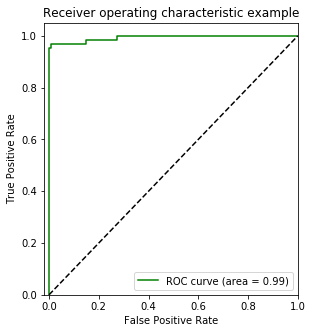

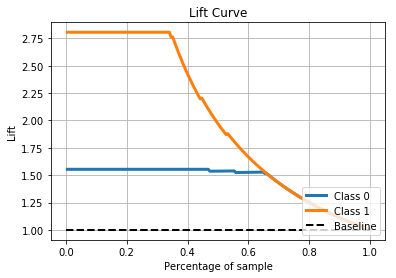

In [24]:
a = lr.predict_proba(X_test_scaled)
fpr, tpr, thresholds = roc_curve(y_test, a[:, 1])
roc_auc = auc(fpr, tpr)
roc_auc
print("AUC value :", roc_auc)
fig = plt.figure(num=None, figsize=(10, 5))

ax1 = plt.subplot("121")
ax1 = plt.plot(fpr, tpr, color='green',
          label='ROC curve (area = %0.2f)' % roc_auc)
ax1 = plt.plot([0, 1], [0, 1], color='black',  linestyle='--')
ax1 = plt.xlim([-0.02, 1.0])
ax1 = plt.ylim([0.0, 1.05])
ax1 = plt.xlabel('False Positive Rate')
ax1 = plt.ylabel('True Positive Rate')
ax1 = plt.title('Receiver operating characteristic example')
ax1 = plt.legend(loc="lower right")
ax2 = plt.subplot("121")
ax2 = scikitplot.metrics.plot_lift_curve(y_test, a[:], title='Lift Curve')
plt.show()

This is a basic model. It gives a very high prediction accuracy as compared to the best decision tree model. The recall score is higher as well.

In [25]:
#hyper-parameter tuning using grid search CV
#I tried using penalty hyperparameter. I tried l1 and l2 regularisation.
parameters = {'penalty': [ 'l2','l1']}
lr1 = LogisticRegression(random_state = 100)
clf_lr = GridSearchCV(lr1, parameters,scoring='accuracy' , cv=5)
clf_lr.fit(X_train_scaled, y_train)
clf_lr.best_score_
print("Best parameters",clf_lr.best_params_)
clf_lr.best_estimator_.fit(X_train_scaled,y_train).score(X_test_scaled, y_test)
print("Prediction Accuracy: ",accuracy_score(y_test, clf_lr.best_estimator_.predict(X_test_scaled)))
print("Recall: ",recall_score(y_test, clf_lr.best_estimator_.predict(X_test_scaled)))
print("F-score: ",f1_score(y_test, clf_lr.best_estimator_.predict(X_test_scaled)))
print("Precision score: ",precision_score(y_test, clf_lr.best_estimator_.predict(X_test_scaled)))
print("Confusion Matrix: \n",confusion_matrix(y_test, clf_lr.best_estimator_.predict(X_test_scaled)))

Best parameters {'penalty': 'l2'}
Prediction Accuracy:  0.9787234042553191
Recall:  0.9701492537313433
F-score:  0.9701492537313433
Precision score:  0.9701492537313433
Confusion Matrix: 
 [[119   2]
 [  2  65]]


AUC value : 0.9935857900579745


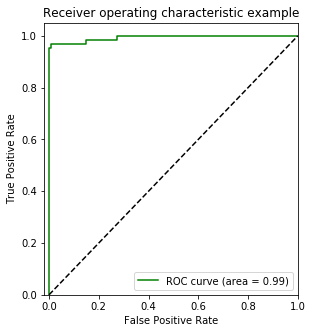

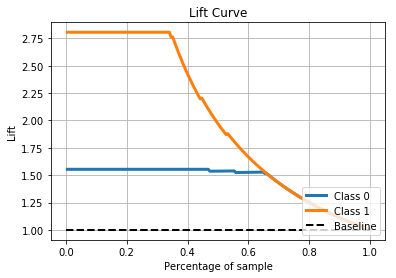

In [26]:
a = clf_lr.best_estimator_.predict_proba(X_test_scaled)
fpr, tpr, thresholds = roc_curve(y_test, a[:, 1])
roc_auc = auc(fpr, tpr)
roc_auc
print("AUC value :", roc_auc)
fig = plt.figure(num=None, figsize=(10, 5))

ax1 = plt.subplot("121")
ax1 = plt.plot(fpr, tpr, color='green',
          label='ROC curve (area = %0.2f)' % roc_auc)
ax1 = plt.plot([0, 1], [0, 1], color='black',  linestyle='--')
ax1 = plt.xlim([-0.02, 1.0])
ax1 = plt.ylim([0.0, 1.05])
ax1 = plt.xlabel('False Positive Rate')
ax1 = plt.ylabel('True Positive Rate')
ax1 = plt.title('Receiver operating characteristic example')
ax1 = plt.legend(loc="lower right")
ax2 = plt.subplot("121")
ax2 = scikitplot.metrics.plot_lift_curve(y_test, a[:], title='Lift Curve')
plt.show()

We observe that the predicition accuracy and recall for logistic regression is greater than that for best model of decision tree. For logistic regression best hyper parameter is penalty = l2.

##KNN

In [27]:
##KNN 
# specify the desired number of neighbors for our kNN classifier. Trying a random value for neighbours
n_neighbors = 3

# create the model
# KNeighborsClassifier is implementing the k-nearest neighbors vote
clf_knn= neighbors.KNeighborsClassifier(n_neighbors)

clf_knn.fit(X_train_scaled, y_train).score(X_test_scaled, y_test)
scores = cross_val_score(clf_knn, X_train_scaled, y_train, cv=4)
scores.mean()
print("Prediction Accuracy: ",accuracy_score(y_test, clf_knn.predict(X_test_scaled)))
print("Average Accuracy cross validation: ",scores.mean())
print("Recall: ",recall_score(y_test, clf_knn.predict(X_test_scaled)))
print("F-score: ",f1_score(y_test, clf_knn.predict(X_test_scaled)))
print("Precision score: ",precision_score(y_test,clf_knn.predict(X_test_scaled)))
print("Confusion Matrix: \n",confusion_matrix(y_test, clf_knn.predict(X_test_scaled)))

Prediction Accuracy:  0.973404255319149
Average Accuracy cross validation:  0.9658991228070175
Recall:  0.9402985074626866
F-score:  0.9618320610687023
Precision score:  0.984375
Confusion Matrix: 
 [[120   1]
 [  4  63]]


AUC value : 0.9898852843221908


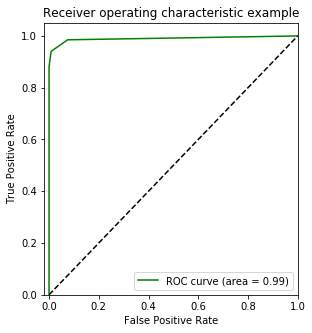

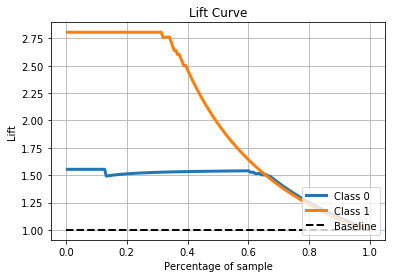

In [28]:
a = clf_knn.predict_proba(X_test_scaled)
fpr, tpr, thresholds = roc_curve(y_test, a[:, 1])
roc_auc = auc(fpr, tpr)
roc_auc
print("AUC value :", roc_auc)
fig = plt.figure(num=None, figsize=(10, 5))

ax1 = plt.subplot("121")
ax1 = plt.plot(fpr, tpr, color='green',
          label='ROC curve (area = %0.2f)' % roc_auc)
ax1 = plt.plot([0, 1], [0, 1], color='black',  linestyle='--')
ax1 = plt.xlim([-0.02, 1.0])
ax1 = plt.ylim([0.0, 1.05])
ax1 = plt.xlabel('False Positive Rate')
ax1 = plt.ylabel('True Positive Rate')
ax1 = plt.title('Receiver operating characteristic example')
ax1 = plt.legend(loc="lower right")
ax2 = plt.subplot("121")
ax2 = scikitplot.metrics.plot_lift_curve(y_test, a[:], title='Lift Curve')
plt.show()

We see that the prediction accuracy for kNN is better than best decision tree model and less than logistic regression. But there is a significant drop in recall score.There might be overfitting in this model. Let's try optimizing the model.

In [29]:
##optimizing the model with different parameters. We run a loop with different values of neighbours and find the maximum score.
l = [i for i in range(1,20)]
score =[]
for i in l:
    s = []
    s.append(i)
    clf = neighbors.KNeighborsClassifier(i)
    a = clf.fit(X_train_scaled, y_train).score(X_test_scaled, y_test)
    s.append(a)
    score.append(s)

In [30]:
score
best_param = 0
a=0.001
for i in score:
    if a<i[1]:
        a=i[1]
    if i[1]==a:
        best_param = i[0]
best_param 
best_score = a
print(best_param, best_score)

18 0.9787234042553191


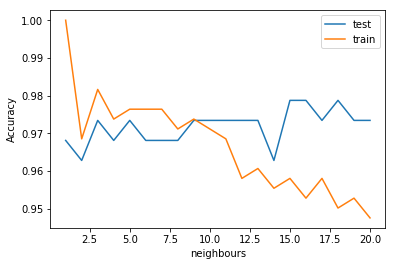

In [31]:

Number_of_features = range(1,21)
train =[]
test = []
for i in Number_of_features:
    clf = neighbors.KNeighborsClassifier(i)
    clf = clf.fit(X_train_scaled, y_train)
    ytrain_pred=clf.predict(X_train_scaled)
    train.append(accuracy_score(y_train, ytrain_pred))
    ytest_pred=clf.predict(X_test_scaled)
    test.append(accuracy_score(y_test, ytest_pred))



line1, =plt.plot(Number_of_features, test,label='test_accuracy')
line2, =plt.plot(Number_of_features, train,label='train_accuracy')
plt.xlabel("neighbours")
plt.ylabel("Accuracy")
plt.legend((line1, line2), ('test', 'train'))
plt.show()


From the graph we see that above 8 or 9 there is overfitting. We try the model with number of neighbours = 8 . We can clearly see the overfitting at low values of neighbours and underfitting at high value of neighbours.

In [32]:
n_neighbors = 8

# create the model
# KNeighborsClassifier is implementing the k-nearest neighbors vote
clf_knn= neighbors.KNeighborsClassifier(n_neighbors)
# Apart from the number of neighbors you can also specify the distance metric to be used
# Wikipedia entry for k-nearest neighbors classifier: http://en.wikipedia.org/wiki/K-nearest_neighbor_algorithm

## Train the model (fit the data)
clf_knn.fit(X_train_scaled, y_train).score(X_test_scaled, y_test)
scores = cross_val_score(clf_knn, X_train_scaled, y_train, cv=4)
scores.mean()
print("Prediction Accuracy: ",accuracy_score(y_test, clf_knn.predict(X_test_scaled)))
print("Average Accuracy cross validation: ",scores.mean())
print("Recall: ",recall_score(y_test, clf_knn.predict(X_test_scaled)))
print("F-score: ",f1_score(y_test, clf_knn.predict(X_test_scaled)))
print("Precision score: ",precision_score(y_test,clf_knn.predict(X_test_scaled)))
print("Confusion Matrix: \n",confusion_matrix(y_test, clf_knn.predict(X_test_scaled)))

Prediction Accuracy:  0.9680851063829787
Average Accuracy cross validation:  0.9501370614035087
Recall:  0.9253731343283582
F-score:  0.9538461538461538
Precision score:  0.9841269841269841
Confusion Matrix: 
 [[120   1]
 [  5  62]]


AUC value : 0.9956827433082521


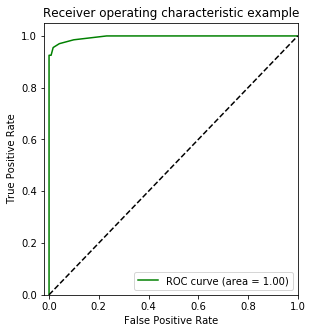

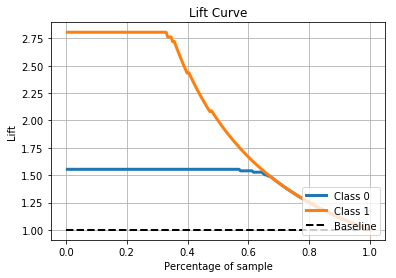

In [33]:
a = clf_knn.predict_proba(X_test_scaled)
fpr, tpr, thresholds = roc_curve(y_test, a[:, 1])
roc_auc = auc(fpr, tpr)
roc_auc
print("AUC value :", roc_auc)
fig = plt.figure(num=None, figsize=(10, 5))

ax1 = plt.subplot("121")
ax1 = plt.plot(fpr, tpr, color='green',
          label='ROC curve (area = %0.2f)' % roc_auc)
ax1 = plt.plot([0, 1], [0, 1], color='black',  linestyle='--')
ax1 = plt.xlim([-0.02, 1.0])
ax1 = plt.ylim([0.0, 1.05])
ax1 = plt.xlabel('False Positive Rate')
ax1 = plt.ylabel('True Positive Rate')
ax1 = plt.title('Receiver operating characteristic example')
ax1 = plt.legend(loc="lower right")
ax2 = plt.subplot("121")
ax2 = scikitplot.metrics.plot_lift_curve(y_test, a[:], title='Lift Curve')
plt.show()

The accuracy of this model is less than the first KNN model. But there is signicant overfitting in the first model. SO we choose this as the best model.

From the above models we see that the best fit model is logistic regression with hyperparameter penalty = l2.
Best parameters {'penalty': 'l2'}
Prediction Accuracy:  0.9787234042553191
Recall:  0.9701492537313433
F-score:  0.9701492537313433
Precision score:  0.9701492537313433
Confusion Matrix: 
 [[119   2]
 [  2  65]]

Best Decision tree:
Prediction Accuracy:  0.9574468085106383
Recall:  0.9552238805970149
F-score:  0.9411764705882353
Precision score:  0.927536231884058
Confusion Matrix: 
 [[116   5]
 [  3  64]]


Best KNN :
 Average Accuracy cross validation:  0.9501370614035087
Recall:  0.9253731343283582
F-score:  0.9538461538461538
Precision score:  0.9841269841269841
Confusion Matrix: 
 [[120   1]
 [  5  62]]
 
 
The recall is highest for this model. The F-score is highest for this model. It is the harmonic mean of recall and precision. 
We can also use F-score for comparing models. For *Malignant cases or class 1* we can see that, the best recall is given by logistic regression, it means that this model predicts the most number of cancer cases correctly as compared to the other two models.

Next, I will try to fit a support vector machine classifier to this dataset.

Support Vector Machines 

In [34]:
clfSVM = SVC(probability=True)
clfSVM.fit(X_train_scaled,y_train)
clfSVM_base_model_score = clfSVM.score(X_test_scaled,y_test)
probab_svm = clfSVM.predict_proba(X_test_scaled)
print("Prediction Accuracy: ",accuracy_score(y_test, clfSVM.predict(X_test_scaled)))
print("Recall: ",recall_score(y_test, clfSVM.predict(X_test_scaled)))
print("F-score: ",f1_score(y_test, clfSVM.predict(X_test_scaled)))
print("Precision score: ",precision_score(y_test,clfSVM.predict(X_test_scaled)))
print("Confusion Matrix: \n",confusion_matrix(y_test, clfSVM.predict(X_test_scaled)))


Prediction Accuracy:  0.9893617021276596
Recall:  1.0
F-score:  0.9852941176470589
Precision score:  0.9710144927536232
Confusion Matrix: 
 [[119   2]
 [  0  67]]


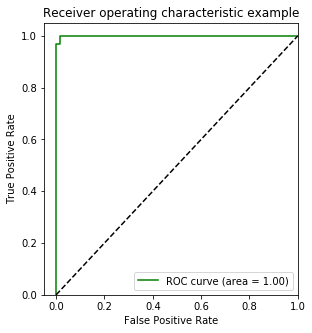

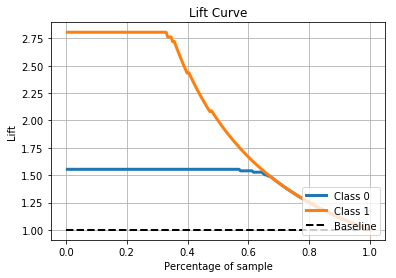

In [35]:
fpr, tpr, thresholds = roc_curve(y_test, probab_svm[:, 1])
roc_auc = auc(fpr, tpr)
fig = plt.figure(num=None, figsize=(10, 5))

ax1 = plt.subplot("121")
ax1 = plt.plot(fpr, tpr, color='green',
          label='ROC curve (area = %0.2f)' % roc_auc)
ax1 = plt.plot([0, 1], [0, 1], color='black', linestyle='--')
ax1 = plt.xlim([-0.05, 1.0])
ax1 = plt.ylim([0.0, 1.05])
ax1 = plt.xlabel('False Positive Rate')
ax1 = plt.ylabel('True Positive Rate')
ax1 = plt.title('Receiver operating characteristic example')
ax1 = plt.legend(loc="lower right")

ax2 = plt.subplot("121")
ax2 = scikitplot.metrics.plot_lift_curve(y_test, a[:], title='Lift Curve')

#GridsearchCV
For tuning the hyperparameters to select the best model I will use GridsearchCV. 
I will tune only kernel and degree hyperparameters for SVC. Using recall as the scoring criterion. 5 folds.

In [36]:
svc = SVC(probability = True)
params = {'kernel':['poly','rbf'],'degree':[2,4,6],'C': [0.001, 0.01, 0.1, 1, 10, 10]}
clf_svc = GridSearchCV(svc, params, scoring = 'recall',cv = 5) 
clf_svc.fit(X_train_scaled,y_train)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=True, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 10],
                         'degree': [2, 4, 6], 'kernel': ['poly', 'rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='recall', verbose=0)

Parameters of best estimator {'C': 10, 'degree': 2, 'kernel': 'rbf'}
Prediction Accuracy:  0.9946808510638298
Recall:  1.0
F-score:  0.9925925925925926
Precision score:  0.9852941176470589
Confusion Matrix: 
 [[120   1]
 [  0  67]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       121
           1       0.99      1.00      0.99        67

    accuracy                           0.99       188
   macro avg       0.99      1.00      0.99       188
weighted avg       0.99      0.99      0.99       188



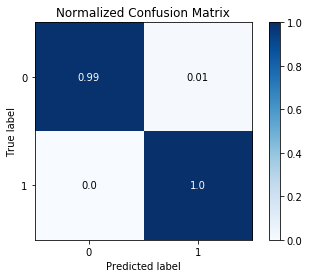

In [37]:
print("Parameters of best estimator",clf_svc.best_params_)
print("Prediction Accuracy: ",accuracy_score(y_test, clf_svc.predict(X_test_scaled)))
print("Recall: ",recall_score(y_test, clf_svc.predict(X_test_scaled)))
print("F-score: ",f1_score(y_test, clf_svc.predict(X_test_scaled)))
print("Precision score: ",precision_score(y_test,clf_svc.predict(X_test_scaled)))
print("Confusion Matrix: \n",confusion_matrix(y_test, clf_svc.predict(X_test_scaled)))
print(classification_report(y_test, clf_svc.predict(X_test_scaled)))
scikitplot.metrics.plot_confusion_matrix(y_test, clf_svc.best_estimator_.predict(X_test_scaled), normalize=True)

AUC score: 1.0


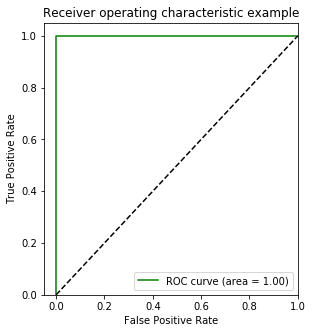

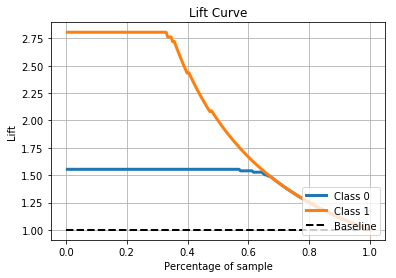

In [38]:

probab_svm = clf_svc.best_estimator_.predict_proba(X_test_scaled)
fpr, tpr, thresholds = roc_curve(y_test, probab_svm[:, 1])
roc_auc = auc(fpr, tpr)
print("AUC score:",roc_auc )
fig = plt.figure(num=None, figsize=(10, 5))

ax1 = plt.subplot("121")
ax1 = plt.plot(fpr, tpr, color='green',
          label='ROC curve (area = %0.2f)' % roc_auc)
ax1 = plt.plot([0, 1], [0, 1], color='black', linestyle='--')
ax1 = plt.xlim([-0.05, 1.0])
ax1 = plt.ylim([0.0, 1.05])
ax1 = plt.xlabel('False Positive Rate')
ax1 = plt.ylabel('True Positive Rate')
ax1 = plt.title('Receiver operating characteristic example')
ax1 = plt.legend(loc="lower right")

ax2 = plt.subplot("121")
ax2 = scikitplot.metrics.plot_lift_curve(y_test, a[:], title='Lift Curve')

plt.show()

Comparing the best models for the four different algorithms

logistic regression with hyperparameter penalty = l2.
Best parameters {'penalty': 'l2'}
Prediction Accuracy:  0.9787234042553191
Recall:  0.9701492537313433
F-score:  0.9701492537313433
Precision score:  0.9701492537313433
Confusion Matrix: 
 [[119   2]
 [  2  65]]
AUC value : 0.9935857900579745

Best Decision tree:
Prediction Accuracy:  0.9574468085106383
Recall:  0.9552238805970149
F-score:  0.9411764705882353
Precision score:  0.927536231884058
Confusion Matrix: 
 [[116   5]
 [  3  64]]
AUC value : 0.964228444554089


Best KNN :
 Average Accuracy cross validation:  0.9501370614035087
Recall:  0.9253731343283582
F-score:  0.9538461538461538
Precision score:  0.9841269841269841
Confusion Matrix: 
 [[120   1]
 [  5  62]]
AUC value : 0.9898852843221908

Best SVM Classifier : 
Parameters of best estimator {'degree': 2, 'kernel': 'rbf'}
Prediction Accuracy:  0.9893617021276596
Recall:  1.0
F-score:  0.9852941176470589
Precision score:  0.9710144927536232
Confusion Matrix: 
 [[119   2]
 [  0  67]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       121
           1       0.97      1.00      0.99        67

    accuracy                           0.99       188
   macro avg       0.99      0.99      0.99       188
weighted avg       0.99      0.99      0.99       188
AUC score: 0.9995065992352289


From the above results we see that the best model so far is for SVM classifier. It out of 67 postive cases it predicts 67 correctly, and out of 121 negative 
cases it misclassifies 2 as positive. 
The AUC for SVM classifier is highest 0.9995

Below I describe one more way to compare the accuracy/other scoring criterion for different hyper parameters. I have avoided this step for all the models to prevent my answer for becoming too large. But a similar approach can be used to understand the and see the effect of different hyperparameters on scoring criterion chosen.

Comparing the accuracy of SVM classifier for different parameters

In [39]:
parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 10], 'gamma' : [0.001, 0.01, 0.1, 1],
              'kernel':['linear', 'poly', 'rbf', 'sigmoid'],'degree':[2,4,6]}
clf = SVC(random_state=100)
scoring = ['recall', 'f1']
for score in scoring:
    print('Model Based on ', score)
    print('#'*100)
    
    grid_clf = GridSearchCV(clf, param_grid=parameters, cv=5, scoring = score)
    grid_clf.fit(X_train_scaled, y_train)
    print('Best SVM classifier parameters ',grid_clf.best_estimator_)
    mean_score = grid_clf.cv_results_['mean_test_score']
    std_score = grid_clf.cv_results_['std_test_score']
    print(score, ' score for different hyperparameters')
    for mean, std_dev, param in zip(mean_score,std_score, grid_clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std_dev * 2, param))
    print('Lets the best model on testing set')
    print('#'*100)
    print(classification_report(y_test, grid_clf.best_estimator_.predict(X_test_scaled)))

Model Based on  recall
####################################################################################################
Best SVM classifier parameters  SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=2, gamma=0.001, kernel='linear',
    max_iter=-1, probability=False, random_state=100, shrinking=True, tol=0.001,
    verbose=False)
recall  score for different hyperparameters
0.814 (+/-0.083) for {'C': 0.001, 'degree': 2, 'gamma': 0.001, 'kernel': 'linear'}
0.000 (+/-0.000) for {'C': 0.001, 'degree': 2, 'gamma': 0.001, 'kernel': 'poly'}
0.000 (+/-0.000) for {'C': 0.001, 'degree': 2, 'gamma': 0.001, 'kernel': 'rbf'}
0.000 (+/-0.000) for {'C': 0.001, 'degree': 2, 'gamma': 0.001, 'kernel': 'sigmoid'}
0.814 (+/-0.083) for {'C': 0.001, 'degree': 2, 'gamma': 0.01, 'kernel': 'linear'}
0.000 (+/-0.000) for {'C': 0.001, 'degree': 2, 'gamma': 0.01, 'kernel': 'poly'}
0.000 (+/-0.000) for {'C': 0.001, 'degree': 2, 'gamma': 0.01, 'kernel': 'rbf'}
0

Best SVM classifier parameters  SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=2, gamma=0.001, kernel='linear',
    max_iter=-1, probability=False, random_state=100, shrinking=True, tol=0.001,
    verbose=False)
f1  score for different hyperparameters
0.897 (+/-0.050) for {'C': 0.001, 'degree': 2, 'gamma': 0.001, 'kernel': 'linear'}
0.000 (+/-0.000) for {'C': 0.001, 'degree': 2, 'gamma': 0.001, 'kernel': 'poly'}
0.000 (+/-0.000) for {'C': 0.001, 'degree': 2, 'gamma': 0.001, 'kernel': 'rbf'}
0.000 (+/-0.000) for {'C': 0.001, 'degree': 2, 'gamma': 0.001, 'kernel': 'sigmoid'}
0.897 (+/-0.050) for {'C': 0.001, 'degree': 2, 'gamma': 0.01, 'kernel': 'linear'}
0.000 (+/-0.000) for {'C': 0.001, 'degree': 2, 'gamma': 0.01, 'kernel': 'poly'}
0.000 (+/-0.000) for {'C': 0.001, 'degree': 2, 'gamma': 0.01, 'kernel': 'rbf'}
0.000 (+/-0.000) for {'C': 0.001, 'degree': 2, 'gamma': 0.01, 'kernel': 'sigmoid'}
0.897 (+/-0.050) for {'C': 0.001, 'degree': 

Using the above technique accuracy for other models can be compared for different hyperparamenters. I have not done that to prevent answer(both code and output) from becoming too long. 

In [40]:
y_test.value_counts()

0    121
1     67
Name: target, dtype: int64

In [41]:
# Number of random trials
NUM_TRIALS = 30



# Set up possible values of parameters to optimize over
p_grid = {"C": [1, 10, 100],
          "gamma": [.01, .1],
          "degree": [2,4,6]}

# We will use a Support Vector Classifier with "rbf" kernel
svm = SVC(kernel="rbf", probability = True)

# Arrays to store scores
non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

# Loop for each trial
for i in range(NUM_TRIALS):

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "GroupKFold", "LeaveOneOut", "LeaveOneGroupOut", etc.
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=inner_cv,
                       iid=False)
    clf.fit(X_train_scaled, y_train)
    non_nested_scores[i] = clf.best_score_

    # Nested CV with parameter optimization
    nested_score = cross_val_score(clf.best_estimator_, X=X_train_scaled, y=y_train, cv=outer_cv)
    nested_scores[i] = nested_score.mean()

score_difference = non_nested_scores - nested_scores


mean score with NestedCV: 0.973766447368421
Parameters of best estimator {'C': 1, 'degree': 2, 'gamma': 0.01}
Prediction Accuracy:  0.9840425531914894
Recall:  0.9552238805970149
F-score:  0.9770992366412213
Precision score:  1.0
Confusion Matrix: 
 [[121   0]
 [  3  64]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       121
           1       1.00      0.96      0.98        67

    accuracy                           0.98       188
   macro avg       0.99      0.98      0.98       188
weighted avg       0.98      0.98      0.98       188



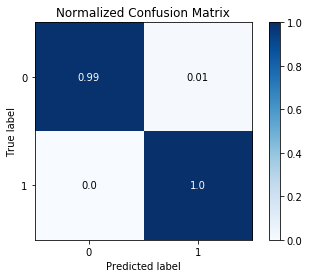

In [42]:
print("mean score with NestedCV:",nested_score.mean())
print("Parameters of best estimator",clf.best_params_)
print("Prediction Accuracy: ",accuracy_score(y_test, clf.best_estimator_.predict(X_test_scaled)))
print("Recall: ",recall_score(y_test, clf.best_estimator_.predict(X_test_scaled)))
print("F-score: ",f1_score(y_test, clf.best_estimator_.predict(X_test_scaled)))
print("Precision score: ",precision_score(y_test,clf.best_estimator_.predict(X_test_scaled)))
print("Confusion Matrix: \n",confusion_matrix(y_test, clf.best_estimator_.predict(X_test_scaled)))
print(classification_report(y_test, clf.best_estimator_.predict(X_test_scaled)))
scikitplot.metrics.plot_confusion_matrix(y_test, clf_svc.best_estimator_.predict(X_test_scaled), normalize=True)

AUC score: 0.9997532996176144


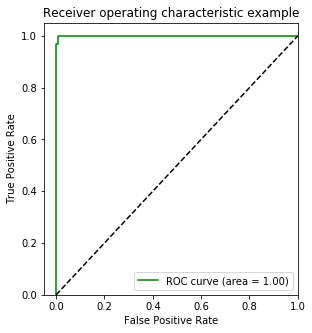

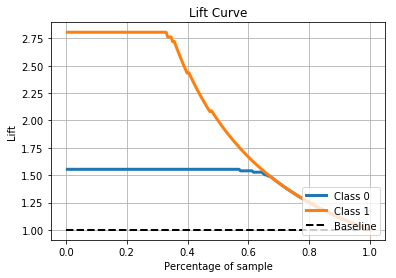

In [43]:
probab_svm = clf.best_estimator_.predict_proba(X_test_scaled)
fpr, tpr, thresholds = roc_curve(y_test, probab_svm[:, 1])
roc_auc = auc(fpr, tpr)
print("AUC score:",roc_auc )
fig = plt.figure(num=None, figsize=(10, 5))

ax1 = plt.subplot("121")
ax1 = plt.plot(fpr, tpr, color='green',
          label='ROC curve (area = %0.2f)' % roc_auc)
ax1 = plt.plot([0, 1], [0, 1], color='black', linestyle='--')
ax1 = plt.xlim([-0.05, 1.0])
ax1 = plt.ylim([0.0, 1.05])
ax1 = plt.xlabel('False Positive Rate')
ax1 = plt.ylabel('True Positive Rate')
ax1 = plt.title('Receiver operating characteristic example')
ax1 = plt.legend(loc="lower right")

ax2 = plt.subplot("121")
ax2 = scikitplot.metrics.plot_lift_curve(y_test, a[:], title='Lift Curve')

plt.show()